# Implementing a Linear Classifier from Scratch

# Data

Data set: [Review polarity v2.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/).

## Data Download

In [0]:
data_url = """http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"""
fn = data_url.split("/")[-1]

import urllib.request
urllib.request.urlretrieve(data_url, fn)
!tar zxf review_polarity.tar.gz
!ls

poldata.README.2.0  review_polarity.tar.gz  sample_data  txt_sentoken


## Data Preprocessing

### Data Reading

In [0]:
import os
filenames = list()
for root, dirs, files in os.walk("./txt_sentoken"):
    for name in files:
          filenames.append(os.path.join(root, name))
print("Found %i files" % len(filenames))

Found 2000 files


In [0]:
import numpy as np

X_txt = list()
y = list()
import random
random.shuffle(filenames)
for i, fn in enumerate(filenames):
    if fn.find("/pos/") > 0:
        msg = "positive"
        y.append(1)
    else:
        msg = "negative"
        y.append(-1)
    with open(fn) as f:
        X_txt.append(f.read())
    if i < 10:
        print(fn, msg, "example")

y = np.asarray(y)
assert len(X_txt) == y.shape[0]

./txt_sentoken/neg/cv649_13947.txt negative example
./txt_sentoken/pos/cv543_5045.txt positive example
./txt_sentoken/pos/cv272_18974.txt positive example
./txt_sentoken/pos/cv907_3541.txt positive example
./txt_sentoken/pos/cv178_12972.txt positive example
./txt_sentoken/neg/cv530_17949.txt negative example
./txt_sentoken/pos/cv631_4967.txt positive example
./txt_sentoken/neg/cv963_7208.txt negative example
./txt_sentoken/pos/cv340_13287.txt positive example
./txt_sentoken/neg/cv044_18429.txt negative example


Then we can check what we get in `X_txt`.

In [0]:
X_txt[:1]

['plot outline - wendy ( samantha press ) , a jazz singer , loves mack ( hugo race ) a criminal and wanna be rock singer who\'s planning a bank heist . \nmack is also being tailed by a couple of cops , one an inexperienced rookie ( dominic sweeney ) , the other ( john flaus ) a worn out veteran who frequents wendy\'s jazz club . \nthey\'re tailing mack , because he has an audiotape that may show evidence of governmental corruption . \nmeanwhile wendy\'s sexually awakener , fifteen year old sister ( rebecca elmaloglou ) has moved in with her , and is secretly watching mack and wendy\'s late night love trysts ? much zaniness ensues \nthe review : main problem first - about 2% of rood rock star to actor conversions in filmdom ever really work . \nunfortunately , trying to cast hugo race as a violent , sexy criminal falls into the " what the hell where they thinking " category that takes up 98% of the rest . \nbut , hell , it\'s not as if he\'s the only problem in this well-intentioned but

## Text Preprocessing

### Tokenization

Here, I just use the space to tokenize a sentence.

Tokenization function:

In [0]:
import re
import string
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)', sent.lower()) if x.strip() and x.strip() not in string.punctuation]

Then we get our simple tokenize function.

### Remove Stopwords and Build a Vocabulary

Get stopwords from NLTK:

In [0]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Build vocabulary and remove stopwords:

In [0]:
voc = []
X_tok = []
for sent in X_txt:
    new_sent = []
    sent_tok = tokenize(sent)
    for word in sent_tok:
        if word not in stopwords:
            new_sent.append(word)
            if word not in voc:
                voc.append(word)
    X_tok.append(new_sent)
import random
random.shuffle(voc)

Build a mapping from word to its index:

In [0]:
word2index = dict((w, i) for i, w in enumerate(voc))

# Feature Extraction

## Bag-of-Word Model (BOW)

In [0]:
import numpy as np

In [0]:
X_vector = np.zeros((len(X_tok), len(voc)))
for sent_i in range(len(X_tok)):
    for word in X_tok[sent_i]:
        X_vector[sent_i, word2index[word]] = 1

Divide `X_vector` into many batches:

In [0]:
batch_size = 64
index = list(range(2000))
random.shuffle(index)
X_tmp = X_vector[index]
y_tmp = y[index]
data_iter = []
num_batch = len(y) // batch_size
for i in range(num_batch):
    X_batch = X_tmp[batch_size * i: batch_size * (i+1)]
    y_batch = y_tmp[batch_size * i: batch_size * (i+1)]
    data_iter.append((X_batch, y_batch))
X_batch = X_tmp[batch_size * num_batch:]
y_batch = y_tmp[batch_size * num_batch:]
data_iter.append((X_batch, y_batch))

## Tf-idf Model

Here, my tfidf formula is:
- Term Frequency (tf):
\begin{equation}
tf_{i,d}=1+\log\left(\frac{N_{i,d}}{N_d}\right),
\end{equation}
where $tf_{i,d}$ represents the tf of word $i$ in document $d$. $N_{i,d}$ represents the frequency of word $i$ in document $d$. $N_d$ represents the number of words in document d.

- Inverse Document Frequency (idf):
\begin{equation}
idf_i=\log\left(1+\frac{|D|}{M_i}\right),
\end{equation}
where $idf_i$ represents the idf of word $i$. $|D|$ represents the number of documents in the dataset. $M_i$ represents the number of documents that contain word $i$.

First, I compute the idf for each word in the vocabulary.

In [0]:
idf = dict()
for word in voc:
  idf[word] = 0
  for sent in X_tok:
    if word in sent:
      idf[word] += 1
      break

In [0]:
for word in idf:
  idf[word] = np.log(1 + 2000 / idf[word])

Then I compute the **tfidf** vector for each document.

In [0]:
from collections import Counter
X_tfidf = np.zeros((2000, len(voc)))
for i in range(2000):
  sent = X_tok[i]
  c = Counter(sent)
  for word in c:
    X_tfidf[i, word2index[word]] = (1 + np.log(c[word] / len(sent))) * idf[word]

# Logistic Regression Model

In this part, I write a class of logistic regression model.

## Class Description:
**Input:**
- **input_size**: the dimension of a sample;
- **learning_rate**: learning rate of gradient descent method;
- **loss_type**: we can use two types of loss function. The first type is `'logistic'` and the second type is `'hinge'`;
- **opt_type**: we can use 6 types of optimization methods here, including `'SGD'`, `'momentum'`, `'RMSprop'`, `'AdaGrad'`, `'AdaDelta'` and `'Adam'`.
- **momentum_beta**: the hyperparameter of momentum optimization method;
- **RMSprop_beta**: the hyperparameter of RMSprop optimization method;
- **AdaDelta_beta**: the hyperparameter of AdaDelta optimization method;
- **Adam_beta1** and **Adam_beta2**: the hyperparameters of Adam optimization method;
- **regularizer**: we can use two types of regularization here, "L1" and "L2";
- **beta**: regularization dampen;

**Methods in the Class:**
- **_sigmoid:** It's used to compute the sigmoid function;
- **forward:** It's used to compute the forward propagation of the model.
$$
\begin{equation}
\begin{split}
y&=sigmoid(z)\\
&=sigmoid(W^Tx).
\end{split}
\end{equation}
$$
- **gradient:** It's use to compute the gradient of $W$. Different loss functions will use different method to compute their gradients. If we use logistics loss function:
$$
\begin{equation}
loss_{logistic}(W)=\frac{1}{N}\sum_i\left[y_i\log\hat{y}_i+(1-y_i)\log\left(1-\hat{y}_i\right)\right],
\end{equation}
$$
the gradient of $W$ is
$$
\begin{equation}
\frac{\partial loss_{logistic}(W)}{\partial W}=\frac{1}{N}\sum_i\left(\hat{y}_i-y_i\right)x_i.
\end{equation}
$$
If we use hinge loss function:
$$
\begin{equation}
loss_{hinge}(W)=\frac{1}{N}\sum_i\max(0,1-y_i\cdot\hat{y}_i),
\end{equation}
$$
the gradient of W is
$$
\begin{equation}
\frac{\partial loss_{hinge}(W)}{\partial W}=\frac{1}{N}\sum_i\begin{cases}
-y_i\cdot\hat{y}_i\cdot(1-\hat{y}_i)x_i\text{, }&1-y_i\cdot\hat{y}_i\geq 0,\\
0\text{, }&others.
\end{cases}
\end{equation}
$$
If we use L2 regularizer in the model, the gradient will be:
$$
\begin{equation}
\frac{\partial loss(W)}{\partial W}+2*\beta W.
\end{equation}
$$
If we use L1 regularizer in the model, the gradient will be:
$$
\begin{equation}
\frac{\partial loss(W)}{\partial W_i}+\begin{cases}
\beta\text{, }&W_i\geq 0,\\
-\beta,\text{, }&others.
\end{cases}
\end{equation}
$$
- **loss_fn:** It is used to compute the loss function.
- **update:** It's used to update the parameter value of the model. It computes an epoch of all the input data.

**Optimization Method in Class:**
Let $g_t$ be the gradient of $W$ at the $t^{th}$ iteration.
- **SGD:**
$$
\begin{equation}
W^{(t+1)}=W^{(t)}-\alpha g_t.
\end{equation}
$$
- **Momentum:**
$$
\begin{equation}
\Delta W^{(t)}=\beta\Delta W^{(t-1)}-\alpha g_{t},
\end{equation}
$$
$$
\begin{equation}
\Delta W^{(0)}=0,
\end{equation}
$$
$$
\begin{equation}
W^{(t+1)}=W^{(t)}+\Delta W^{(t)}.
\end{equation}
$$
- **RMSprop:**
$$
\begin{equation}
G_t=\beta G_{t-1}+(1-\beta)g_t\odot g_t,
\end{equation}
$$
$$
G_0=0,
$$
$$
\begin{equation}
W^{(t+1)}=W^{(t)}-\frac{\alpha}{\sqrt{G_t+\epsilon}}\odot g_t.
\end{equation}
$$
- **AdaGrad:**
$$
Gt=\sum_{r=1}^tg_r\odot g_r,
$$
$$
\begin{equation}
W^{(t+1)}=W^{(t)}-\frac{\alpha}{\sqrt{G_t+\epsilon}}\odot g_t.
\end{equation}
$$
- **AdaDelta:**
$$
\Delta X^2_{t-1}=\Delta X^2_{t-2} + (1-\beta_1)\Delta W^{(t-1)}\odot \Delta W^{(t-1)},
$$
$$
G_t=\beta G_{t-1}+(1-\beta)g_t\odot g_t,
$$
$$
\Delta X_0^2=0, \Delta G_0=0,
$$
$$
W^{(t+1)}=W^{(t)}-\frac{\sqrt{\Delta X_{t-1}^2+\epsilon}}{\sqrt{G_t+\epsilon}}g_t.
$$
- **Adam:**
$$
M_t=\beta_1M_{t-1}+(1-\beta_1)g_t,
$$
$$
G_t=\beta_2G_{t-1}+(1-\beta_2)g_t\odot g_t,
$$
$$
M_0=0, G_0=0,
$$
$$
\hat{M}_t=\frac{M_t}{1-\beta_1^t},
$$
$$
\hat{G}_t=\frac{G_t}{1-\beta_2^t},
$$
$$
W^{(t+1)}=W^{(t)}-\frac{\alpha}{\sqrt{\hat{G}_t+\epsilon}}\hat{M}_t.
$$

In [0]:
class LR:
    def __init__(self, input_size=2, learning_rate=0.001, loss_type='logistic', opt_type='SGD',
                momentum_beta=0.9, RMSprop_beta=0.9, AdaDelta_beta=0.9, Adam_beta1=0.9, Adam_beta2=0.99,
                regularizer='L2', beta=0.01):
        self.input_size = input_size + 1
        self.W = np.zeros((self.input_size, 1))
        self.lr = learning_rate
        self.loss_type = loss_type
        self.opt_type = opt_type
        self.regularizer = regularizer
        self.beta = beta
        self.momentum_beta = momentum_beta
        self.RMSprop_beta = RMSprop_beta
        self.AdaDelta_beta = AdaDelta_beta
        self.Adam_beta1 = Adam_beta1
        self.Adam_beta2 = Adam_beta2
        self.pre_change = 0 # use to store pre_change value in momentum and AdaDelta methods
        self.pre_G = 0 # use to store G value in AdaGrad, AdaDelta, RMSprop and Adam methods
        self.pre_X = 0 # use to store X value in AdaDelta method
        self.pre_M = 0 # use to store M value in Adam method
        self.iter_times = 0 # use to store iteration times in Adam method
    
    def _sigmoid(self, a):
        """
        sigmoid function
        """
        return 1 / (1 + np.exp(-a))
    
    def forward(self, X):
        """
        Forward propagation
        Input:
            X: size = [batch_size, self.input_size - 1]
        Output:
            out: sigmoid(X @ W), size = [batch_size, 1]
        """
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=-1)
        self.X = X
        return self._sigmoid(self.X @ self.W)
    
    def gradient(self, pred):
        """
        gradient computation function
        """
        if self.loss_type == "logistic":
            self.grad = np.dot(self.X.T, pred - self.y) / self.y.shape[0]
        elif self.loss_type == 'hinge':
            self.grad = -self.y * pred * (1 - pred) * self.X
            self.grad = np.where((1 - self.y * pred) > 0, self.grad, 0)
            self.grad = (self.grad.sum(axis=0) / self.y.shape[0]).reshape(-1, 1)
        
        if self.regularizer == "L2":
            self.grad += self.beta * 2 * self.W
        elif self.regularizer == "L1":
            self.grad += self.beta * np.where(self.W > 0, np.ones_like(self.W), -1)
    
    def loss_fn(self, pred):
        if self.loss_type == "logistic":
            loss = (- self.y * np.log(pred) - (1 - self.y) * np.log(1 - pred)).mean()
        elif self.loss_type == "hinge":
            loss = np.maximum(np.zeros_like(self.y), 1 - self.y * pred).mean()
        return loss
    
    def update(self, X, y):
        self.y = y
        pred = self.forward(X)
        self.gradient(pred)
        if self.opt_type == "SGD":
            self.W -= self.lr * self.grad
        elif self.opt_type == "momentum":
            self.pre_change = self.momentum_beta * self.pre_change - self.lr * self.grad
            self.W += self.pre_change
        elif self.opt_type == "RMSprop":
            self.pre_G = self.RMSprop_beta * self.pre_G + (1 - self.RMSprop_beta) * self.grad * self.grad
            self.W += -self.lr * self.grad / np.sqrt(self.pre_G + 1e-8)
        elif self.opt_type == "AdaGrad":
            self.pre_G += self.grad * self.grad
            self.W += -self.lr * self.grad / np.sqrt(self.pre_G + 1e-8)
        elif self.opt_type == "AdaDelta":
            self.pre_G = self.RMSprop_beta * self.pre_G + (1 - self.RMSprop_beta) * self.grad * self.grad
            self.pre_X = self.AdaDelta_beta * self.pre_X + (1 - self.AdaDelta_beta) * self.pre_change * self.pre_change
            self.pre_change = -np.sqrt(self.pre_X + 1e-8) / np.sqrt(self.pre_G + 1e-8) * self.grad
            self.W += self.pre_change
        elif self.opt_type == "Adam":
            self.iter_times += 1
            self.pre_M = self.Adam_beta1 * self.pre_M + (1 - self.Adam_beta1) * self.grad
            self.pre_G = self.Adam_beta2 * self.pre_G + (1 - self.Adam_beta2) * self.grad * self.grad
            hat_M = self.pre_M / (1 - self.Adam_beta1 ** self.iter_times)
            hat_G = self.pre_G / (1 - self.Adam_beta2 ** self.iter_times)
            self.W += -self.lr * hat_M / np.sqrt(hat_G + 1e-8)
        return self.loss_fn(pred)

## Comparasion of Different Optimization Methods

In [0]:
opt_method = ["SGD", "momentum", "RMSprop", "AdaGrad", "AdaDelta", "Adam"]
opt_loss = []
for opt in opt_method:
    model = LR(input_size=X_vector.shape[1], opt_type=opt)
    losslist = []
    for epoch in range(100):
        total_loss = 0.
        for batch_data in data_iter:
            X_batch, y_batch = batch_data
            y_batch[y_batch < 0] = 0
            total_loss += model.update(X_batch, y_batch.reshape(-1, 1))
        losslist.append(total_loss/2000)
    opt_loss.append(losslist)

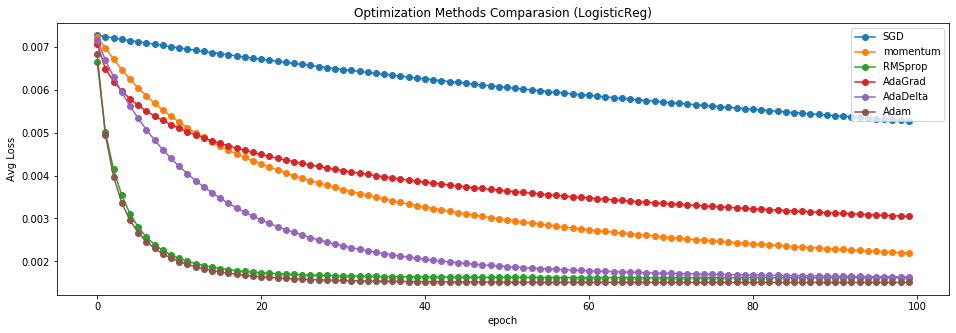

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
for i in range(len(opt_method)):
    plt.plot(list(range(100)), opt_loss[i], marker='o')
plt.legend(opt_method)
plt.xlabel('epoch')
plt.ylabel('Avg Loss')
plt.title('Optimization Methods Comparasion (LogisticReg)')
plt.show()

From the figure above, we can find that `SGD` is a poor optimization and `Adam` is the best optimization method in this problem.

# Exploring hyperparameters

In [0]:
num_epochs = 100

We first need to split our data set into two sets: training set and test set.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.33,
                                                    random_state=42)

Then we need to divide our data into many batches.

In [0]:
batch_size = 64
import random
index = list(range(len(X_train)))
random.shuffle(index)
X_tmp = X_train[index]
y_tmp = y_train[index]
data_iter = []
num_batch = len(y_train) // batch_size
for i in range(num_batch):
    X_batch = X_tmp[batch_size * i: batch_size * (i+1)]
    y_batch = y_tmp[batch_size * i: batch_size * (i+1)]
    data_iter.append((X_batch, y_batch))
X_batch = X_tmp[batch_size * num_batch:]
y_batch = y_tmp[batch_size * num_batch:]
data_iter.append((X_batch, y_batch))

## Basic model testing:

I first test my model to check whether there are some problems in my code.

### Logistic loss:

In [0]:
model = LR(input_size=X_train.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='SGD', regularizer='L2', beta=0.003)
for epoch in range(100):
    total_loss = 0.
    for batch_data in data_iter:
        X_batch, y_batch = batch_data
        y_batch[y_batch < 0] = 0
        total_loss += model.update(X_batch, y_batch.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}. Avg Loss: {total_loss/len(y_train):.8f}.")

Epoch: 20/100. Avg Loss: 0.01005448.
Epoch: 40/100. Avg Loss: 0.00935750.
Epoch: 60/100. Avg Loss: 0.00877165.
Epoch: 80/100. Avg Loss: 0.00827228.
Epoch: 100/100. Avg Loss: 0.00784094.


In [0]:
pred = model.forward(X_test)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

The accuracy on the test set is 82.121%.


### Hinge loss:

In [0]:
model = LR(input_size=X_train.shape[1], learning_rate=3.0, loss_type='hinge',
           opt_type='SGD', regularizer=None)
for epoch in range(100):
    total_loss = 0.
    for batch_data in data_iter:
        X_batch, y_batch = batch_data
        y_batch[y_batch < 1] = -1
        total_loss += model.update(X_batch, y_batch.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}. Avg Loss: {total_loss/len(y_train):.8f}.")

Epoch: 20/100. Avg Loss: 0.00802732.
Epoch: 40/100. Avg Loss: 0.00798135.
Epoch: 60/100. Avg Loss: 0.00797291.
Epoch: 80/100. Avg Loss: 0.00796867.
Epoch: 100/100. Avg Loss: 0.00796611.


In [0]:
pred = model.forward(X_test)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for hinge loss is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

The accuracy on the test set for hinge loss is 86.818%.


After the experiment above, I think my code is right.

## Logistic Loss Hyperparameters Exploration

### Logistic Loss Learning Rate

In this part, I will keep other hyperparameters unchanged and only use different learning rates to test the logistics model with logistic loss.

In [0]:
from sklearn.model_selection import KFold
Learning_rate = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 1.0, 3.0]

Then I will do the 10-folds validation on the training set for my the logistics regression model.

In [0]:
mean_validation_accuracy = list()
for lr in Learning_rate:
  validation_accuracy = []
  for train, val in KFold(n_splits=10, shuffle=True).split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    y_tr[y_tr < 0] = 0
    X_val = X_train[val]
    y_val = y_train[val]
    y_val[y_val < 0] = 0
    model = LR(input_size=X_train.shape[1], learning_rate=lr, loss_type='logistic',
              opt_type='SGD', regularizer=None)
    for epoch in range(100):
      model.update(X_tr, y_tr.reshape(-1, 1))
    pred = model.forward(X_val)
    pred[pred>0.5] = 1
    pred[pred<0.5] = 0
    acc = (pred==y_val.reshape(-1,1)).sum()/len(y_val)
    validation_accuracy.append(acc)
  mean_validation_accuracy.append(np.mean(validation_accuracy))
  print(f"The mean accuracy of the validation set of lr {lr} is {mean_validation_accuracy[-1]:.3%}.")

The mean accuracy of the validation set of lr 0.0001 is 68.657%.
The mean accuracy of the validation set of lr 0.0003 is 69.552%.
The mean accuracy of the validation set of lr 0.001 is 73.657%.
The mean accuracy of the validation set of lr 0.003 is 79.403%.
The mean accuracy of the validation set of lr 0.01 is 81.567%.
The mean accuracy of the validation set of lr 0.03 is 82.985%.
The mean accuracy of the validation set of lr 1.0 is 86.567%.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


The mean accuracy of the validation set of lr 3.0 is 85.597%.


In [0]:
import pandas as pd
lr_index = ['lr='+str(lr) for lr in Learning_rate]
pd.DataFrame(mean_validation_accuracy, columns=['Mean Validation Acc'], index=lr_index)


,Mean Validation Acc
lr=0.0001,0.686567
lr=0.0003,0.695522
lr=0.001,0.736567
lr=0.003,0.794030
lr=0.01,0.815672
lr=0.03,0.829851
lr=1.0,0.865672
lr=3.0,0.855970


From the table above, we can find that the best learning rate is $1.0$.

### Logistic Loss Regularization

Here, I will compare two different regularization methods: L1 regularization and L2 regularization.

In [0]:
regularization = ['L1', 'L2']

Then I will do the 10-folds validation on the training set for my the logistics regression model.

In [0]:
mean_validation_accuracy1 = list()
for r in regularization:
  validation_accuracy = []
  for train, val in KFold(n_splits=10, shuffle=True).split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    y_tr[y_tr < 0] = 0
    X_val = X_train[val]
    y_val = y_train[val]
    y_val[y_val < 0] = 0
    model = LR(input_size=X_train.shape[1], learning_rate=0.01, loss_type='logistic',
              opt_type='SGD', regularizer=r)
    for epoch in range(100):
      model.update(X_tr, y_tr.reshape(-1, 1))
    pred = model.forward(X_val)
    pred[pred>0.5] = 1
    pred[pred<0.5] = 0
    acc = (pred==y_val.reshape(-1,1)).sum()/len(y_val)
    validation_accuracy.append(acc)
  mean_validation_accuracy1.append(np.mean(validation_accuracy))
  print(f"The mean accuracy of the validation set of {r} regularization is {mean_validation_accuracy1[-1]:.3%}.")

The mean accuracy of the validation set of L1 regularization is 78.358%.
The mean accuracy of the validation set of L2 regularization is 81.940%.


In [0]:
import pandas as pd
pd.DataFrame(mean_validation_accuracy1, columns=['Mean Validation Acc'], index=['L1', 'L2'])

,Mean Validation Acc
L1,0.783582
L2,0.819403


From the table above, we can find that L2 regularization is better than L1.

### Logistic Loss Regularizer dampening

In this part, I will find how much the regularizer needs to be dampened to get a good score.

In [0]:
re_damp = [0.001, 0.003, 0.005, 0.007, 0.009, 0.5, 1.0]

Then I will do the 10-folds validation on the training set for my the logistics regression model.

In [0]:
mean_validation_accuracy2 = list()
for rd in re_damp:
  validation_accuracy = []
  for train, val in KFold(n_splits=10, shuffle=True).split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    y_tr[y_tr < 0] = 0
    X_val = X_train[val]
    y_val = y_train[val]
    y_val[y_val < 0] = 0
    model = LR(input_size=X_train.shape[1], learning_rate=1.0, loss_type='logistic',
              opt_type='SGD', regularizer="L2", beta=rd)
    for epoch in range(100):
      model.update(X_tr, y_tr.reshape(-1, 1))
    pred = model.forward(X_val)
    pred[pred>0.5] = 1
    pred[pred<0.5] = 0
    acc = (pred==y_val.reshape(-1,1)).sum()/len(y_val)
    validation_accuracy.append(acc)
  mean_validation_accuracy2.append(np.mean(validation_accuracy))
  print(f"The mean accuracy of the validation set of regu_damp {rd} is {mean_validation_accuracy2[-1]:.3%}.")

The mean accuracy of the validation set of regu_damp 0.001 is 86.567%.
The mean accuracy of the validation set of regu_damp 0.003 is 86.791%.
The mean accuracy of the validation set of regu_damp 0.005 is 86.642%.
The mean accuracy of the validation set of regu_damp 0.007 is 86.269%.
The mean accuracy of the validation set of regu_damp 0.009 is 62.612%.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


The mean accuracy of the validation set of regu_damp 0.5 is 51.343%.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


The mean accuracy of the validation set of regu_damp 1.0 is 51.642%.


In [0]:
re_dam_index = ['beta='+str(rd) for rd in re_damp]
pd.DataFrame(mean_validation_accuracy2, columns=['Mean Validation Acc'], index=re_dam_index)

,Mean Validation Acc
beta=0.001,0.865672
beta=0.003,0.867910
beta=0.005,0.866418
beta=0.007,0.862687
beta=0.009,0.626119
beta=0.5,0.513433
beta=1.0,0.516418


From the table above, we can find that the best regularizer dampen for L2 regularization is $0.003$.

### Final set of hyperparameters for Logistic loss

- Learning rate: 1.0
- Regularization: L2
- Regularization dampen: 0.003

## Hinge Loss Hyperparameters Exploration

### Hinge Loss Learning Rate

In [0]:
Learning_rate = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 1.0, 3.0]

Then I will do the 10-folds validation on the training set for my the logistics regression model with hinge loss function.

In [0]:
mean_validation_accuracy3 = list()
for lr in Learning_rate:
  validation_accuracy = []
  for train, val in KFold(n_splits=10, shuffle=True).split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    X_val = X_train[val]
    y_val = y_train[val]
    model = LR(input_size=X_train.shape[1], learning_rate=lr, loss_type='hinge',
              opt_type='SGD', regularizer="L2")
    for epoch in range(100):
      model.update(X_tr, y_tr.reshape(-1, 1))
    pred = model.forward(X_val)
    pred[pred>0.5] = 1
    pred[pred<0.5] = -1
    acc = (pred==y_val.reshape(-1,1)).sum()/len(y_val)
    validation_accuracy.append(acc)
  mean_validation_accuracy3.append(np.mean(validation_accuracy))
  print(f"The mean accuracy of the validation set of lr {lr} is {mean_validation_accuracy3[-1]:.3%}.")

The mean accuracy of the validation set of lr 0.0001 is 73.582%.
The mean accuracy of the validation set of lr 0.0003 is 68.582%.
The mean accuracy of the validation set of lr 0.001 is 75.299%.
The mean accuracy of the validation set of lr 0.003 is 74.328%.
The mean accuracy of the validation set of lr 0.01 is 78.358%.
The mean accuracy of the validation set of lr 0.03 is 80.224%.
The mean accuracy of the validation set of lr 1.0 is 76.940%.
The mean accuracy of the validation set of lr 3.0 is 63.209%.


In [0]:
lr_index = ['lr='+str(lr) for lr in Learning_rate]
pd.DataFrame(mean_validation_accuracy3, columns=['Mean Validation Acc'], index=lr_index)

,Mean Validation Acc
lr=0.0001,0.735821
lr=0.0003,0.685821
lr=0.001,0.752985
lr=0.003,0.743284
lr=0.01,0.783582
lr=0.03,0.802239
lr=1.0,0.769403
lr=3.0,0.632090


From the table above, the best learning rate for hinge loss is 0.03.

### Hinge Loss Regularization

Here, I will compare two different regularization methods: L1 regularization and L2 regularization.

In [0]:
regularization = ['L1', 'L2']

Then I will do the 10-folds validation on the training set for my the logistics regression model.

In [0]:
from sklearn.model_selection import KFold
mean_validation_accuracy4 = list()
for r in regularization:
  validation_accuracy = []
  for train, val in KFold(n_splits=10, shuffle=True).split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    X_val = X_train[val]
    y_val = y_train[val]
    model = LR(input_size=X_train.shape[1], learning_rate=0.03, loss_type='hinge',
              opt_type='SGD', regularizer=r)
    for epoch in range(100):
      model.update(X_tr, y_tr.reshape(-1, 1))
    pred = model.forward(X_val)
    pred[pred>0.5] = 1
    pred[pred<0.5] = -1
    acc = (pred==y_val.reshape(-1,1)).sum()/len(y_val)
    validation_accuracy.append(acc)
  mean_validation_accuracy4.append(np.mean(validation_accuracy))
  print(f"The mean accuracy of the validation set of {r} regularization is {mean_validation_accuracy4[-1]:.3%}.")

The mean accuracy of the validation set of L1 regularization is 67.687%.
The mean accuracy of the validation set of L2 regularization is 80.597%.


In [0]:
import pandas as pd
pd.DataFrame(mean_validation_accuracy4, columns=['Mean Validation Acc'], index=['L1', 'L2'])

,Mean Validation Acc
L1,0.676866
L2,0.805970


From the table above, we can find that the better regularization for hinge loss is L2.

### Hinge Loss Regularizer dampening

In this part, I will find how much the regularizer needs to be dampened to get a good score.

In [0]:
re_damp = [0.001, 0.003, 0.005, 0.007, 0.009, 0.5, 1.0]

Then I will do the 10-folds validation on the training set for my logistics regression model.

In [0]:
mean_validation_accuracy5 = list()
for rd in re_damp:
  validation_accuracy = []
  for train, val in KFold(n_splits=10, shuffle=True).split(X_train):
    X_tr = X_train[train]
    y_tr = y_train[train]
    X_val = X_train[val]
    y_val = y_train[val]
    model = LR(input_size=X_train.shape[1], learning_rate=0.03, loss_type='hinge',
              opt_type='SGD', regularizer="L2", beta=rd)
    for epoch in range(100):
      model.update(X_tr, y_tr.reshape(-1, 1))
    pred = model.forward(X_val)
    pred[pred>0.5] = 1
    pred[pred<0.5] = -1
    acc = (pred==y_val.reshape(-1,1)).sum()/len(y_val)
    validation_accuracy.append(acc)
  mean_validation_accuracy5.append(np.mean(validation_accuracy))
  print(f"The mean accuracy of the validation set of regu_damp {rd} is {mean_validation_accuracy5[-1]:.3%}.")

The mean accuracy of the validation set of regu_damp 0.001 is 79.925%.
The mean accuracy of the validation set of regu_damp 0.003 is 79.851%.
The mean accuracy of the validation set of regu_damp 0.005 is 80.672%.
The mean accuracy of the validation set of regu_damp 0.007 is 80.597%.
The mean accuracy of the validation set of regu_damp 0.009 is 80.448%.
The mean accuracy of the validation set of regu_damp 0.5 is 77.687%.
The mean accuracy of the validation set of regu_damp 1.0 is 77.239%.


In [0]:
re_dam_index = ['beta='+str(rd) for rd in re_damp]
pd.DataFrame(mean_validation_accuracy5, columns=['Mean Validation Acc'], index=re_dam_index)

,Mean Validation Acc
beta=0.001,0.799254
beta=0.003,0.798507
beta=0.005,0.806716
beta=0.007,0.805970
beta=0.009,0.804478
beta=0.5,0.776866
beta=1.0,0.772388


From the table above, we can find that the best L2 regularization dampen for hinge loss is 0.005.

### Final set of hyperparameters for Hinge loss
- Learning Rate: 0.03
- Regularization: L2
- Regularization dampen: 0.005

## Final Comparasion between hinge loss and logistic loss

### Logistics loss:

In [0]:
logistic_model = LR(input_size=X_train.shape[1], learning_rate=1.0, loss_type='logistic',
                    opt_type='SGD', regularizer='L2', beta=0.003)
for epoch in range(100):
    total_loss = 0.
    for batch_data in data_iter:
        X_batch, y_batch = batch_data
        y_batch[y_batch < 0] = 0
        total_loss += logistic_model.update(X_batch, y_batch.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}. Avg Loss: {total_loss/len(y_train):.8f}.")

Epoch: 20/100. Avg Loss: 0.00104613.
Epoch: 40/100. Avg Loss: 0.00104451.
Epoch: 60/100. Avg Loss: 0.00104445.
Epoch: 80/100. Avg Loss: 0.00104444.
Epoch: 100/100. Avg Loss: 0.00104444.


In [0]:
pred = logistic_model.forward(X_test)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for logistics loss is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

The accuracy on the test set for logistics loss is 87.273%.


### Hinge Loss:

In [0]:
hinge_model = LR(input_size=X_train.shape[1], learning_rate=0.03, loss_type='hinge',
                opt_type='SGD', regularizer='L2', beta=0.005)
for epoch in range(100):
    total_loss = 0.
    for batch_data in data_iter:
        X_batch, y_batch = batch_data
        y_batch[y_batch < 1] = -1
        total_loss += hinge_model.update(X_batch, y_batch.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}. Avg Loss: {total_loss/len(y_train):.8f}.")

Epoch: 20/100. Avg Loss: 0.01201730.
Epoch: 40/100. Avg Loss: 0.01089964.
Epoch: 60/100. Avg Loss: 0.01037005.
Epoch: 80/100. Avg Loss: 0.01006413.
Epoch: 100/100. Avg Loss: 0.00986969.


In [0]:
pred = hinge_model.forward(X_test)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for hinge loss is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

The accuracy on the test set for hinge loss is 85.152%.


### Comparasion

In [0]:
pd.DataFrame(data=[0.87273, 0.85152], index=['Logistics Loss', 'Hinge Loss'], columns=['Finally Test Set Acc'])

,Finally Test Set Acc
Logistics Loss,0.87273
Hinge Loss,0.85152


We can see that the accuracy of logistics loss is higher than hinge loss.

### Plot the weight of logistics loss model:

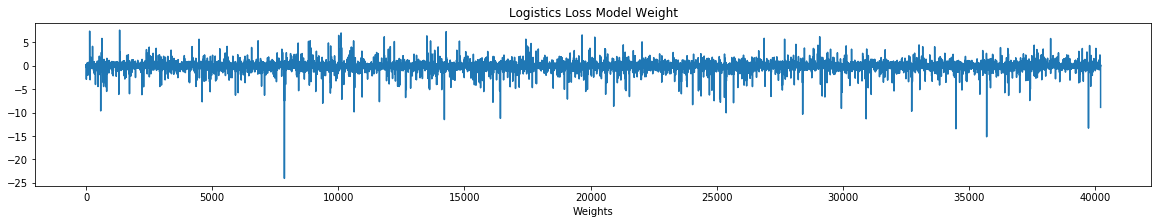

In [0]:
plt.figure(figsize=(20, 3))
plt.plot(logistic_model.W.ravel())
plt.xlabel("Value")
plt.xlabel("Weights")
plt.title("Logistics Loss Model Weight")
plt.show()

### Plot the weight of hinge loss model:

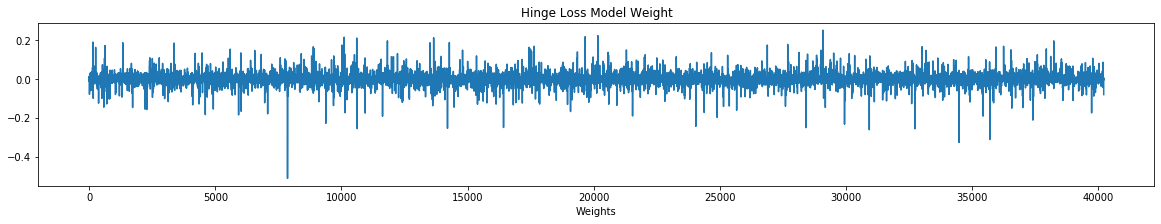

In [0]:
plt.figure(figsize=(20, 3))
plt.plot(hinge_model.W.ravel())
plt.xlabel("Value")
plt.xlabel("Weights")
plt.title("Hinge Loss Model Weight")
plt.show()

# Extra

Create training and test data:

In [0]:
index = list(range(2000))
random.shuffle(index)
train_index = index[:1500]
test_index = index[1500:]
X_train_bow = X_vector[train_index]
X_test_bow = X_vector[test_index]
X_train_tfidf = X_vector[train_index]
X_test_tfidf = X_vector[test_index]
y_train = y[train_index]
y_test = y[test_index]

I will compare 6 different models:
- Logistic+bow+sgd
- Logistic+bow+RMSprop
- Logistic+bow+momentum
- Logistic+tfidf+sgd
- Logistic+tfidf+RMSprop
- Logistic+tfidf+momentum

These models use the same learning rate and the same loss function. Also they don't use any regularization method.

### (1) Logistic+bow+sgd

In [0]:
model = LR(input_size=X_train_bow.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='SGD', regularizer=None)
for epoch in range(100):
    y_train[y_train < 1] = 0
    total_loss = model.update(X_train_bow, y_train.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{100}. Avg Loss: {total_loss/len(y_train):.8f}.")
pred = model.forward(X_test_bow)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for \"Logistic+bow+sgd\" is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

Epoch: 20/100. Avg Loss: 0.00046035.
Epoch: 40/100. Avg Loss: 0.00045855.
Epoch: 60/100. Avg Loss: 0.00045679.
Epoch: 80/100. Avg Loss: 0.00045505.
Epoch: 100/100. Avg Loss: 0.00045333.
The accuracy on the test set for "Logistic+bow+sgd" is 60.600%.


### (2) Logistic+bow+RMSprop

In [0]:
model = LR(input_size=X_train_bow.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='RMSprop', regularizer=None)
for epoch in range(100):
    y_train[y_train < 1] = 0
    total_loss = model.update(X_train_bow, y_train.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{1000}. Avg Loss: {total_loss/len(y_train):.8f}.")
pred = model.forward(X_test_bow)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for \"Logistic+bow+RMSprop\" is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

Epoch: 20/1000. Avg Loss: 0.00018256.
Epoch: 40/1000. Avg Loss: 0.00009934.
Epoch: 60/1000. Avg Loss: 0.00005706.
Epoch: 80/1000. Avg Loss: 0.00003427.
Epoch: 100/1000. Avg Loss: 0.00002158.
The accuracy on the test set for "Logistic+bow+RMSprop" is 83.600%.


### (3) Logistic+bow+momentum

In [0]:
model = LR(input_size=X_train_bow.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='momentum', regularizer=None)
for epoch in range(100):
    y_train[y_train < 1] = 0
    total_loss = model.update(X_train_bow, y_train.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{100}. Avg Loss: {total_loss/len(y_train):.8f}.")
pred = model.forward(X_test_bow)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for \"Logistic+bow+momentum\" is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

Epoch: 20/100. Avg Loss: 0.00045214.
Epoch: 40/100. Avg Loss: 0.00043667.
Epoch: 60/100. Avg Loss: 0.00042167.
Epoch: 80/100. Avg Loss: 0.00040777.
Epoch: 100/100. Avg Loss: 0.00039495.
The accuracy on the test set for "Logistic+bow+momentum" is 80.400%.


### (4) Logistic+tfidf+sgd

In [0]:
model = LR(input_size=X_train_tfidf.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='SGD', regularizer=None)
for epoch in range(100):
    y_train[y_train < 1] = 0
    total_loss = model.update(X_train_tfidf, y_train.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{100}. Avg Loss: {total_loss/len(y_train):.8f}.")
pred = model.forward(X_test_tfidf)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for \"Logistic+tfidf+sgd\" is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

Epoch: 20/100. Avg Loss: 0.00046035.
Epoch: 40/100. Avg Loss: 0.00045855.
Epoch: 60/100. Avg Loss: 0.00045679.
Epoch: 80/100. Avg Loss: 0.00045505.
Epoch: 100/100. Avg Loss: 0.00045333.
The accuracy on the test set for "Logistic+tfidf+sgd" is 60.600%.


### (5) Logistic+tfidf+RMSprop

In [0]:
model = LR(input_size=X_train_tfidf.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='RMSprop', regularizer=None)
for epoch in range(100):
    y_train[y_train < 1] = 0
    total_loss = model.update(X_train_tfidf, y_train.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{100}. Avg Loss: {total_loss/len(y_train):.8f}.")
pred = model.forward(X_test_tfidf)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for \"Logistic+tfidf+RMSprop\" is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

Epoch: 20/100. Avg Loss: 0.00018256.
Epoch: 40/100. Avg Loss: 0.00009934.
Epoch: 60/100. Avg Loss: 0.00005706.
Epoch: 80/100. Avg Loss: 0.00003427.
Epoch: 100/100. Avg Loss: 0.00002158.
The accuracy on the test set for "Logistic+tfidf+RMSprop" is 83.600%.


### (6) Logistic+tfidf+momentum

In [0]:
model = LR(input_size=X_train_tfidf.shape[1], learning_rate=0.001, loss_type='logistic',
           opt_type='momentum', regularizer=None)
for epoch in range(100):
    y_train[y_train < 1] = 0
    total_loss = model.update(X_train_tfidf, y_train.reshape(-1, 1))
    if (epoch+1) % 20 == 0:
        print(f"Epoch: {epoch+1}/{100}. Avg Loss: {total_loss/len(y_train):.8f}.")
pred = model.forward(X_test_tfidf)
pred[pred>0.5] = 1
pred[pred<0.5] = -1
print(f"The accuracy on the test set for \"Logistic+tfidf+momentum\" is {(pred==y_test.reshape(-1,1)).sum()/len(y_test):.3%}.")

Epoch: 20/100. Avg Loss: 0.00045214.
Epoch: 40/100. Avg Loss: 0.00043667.
Epoch: 60/100. Avg Loss: 0.00042167.
Epoch: 80/100. Avg Loss: 0.00040777.
Epoch: 100/100. Avg Loss: 0.00039495.
The accuracy on the test set for "Logistic+tfidf+momentum" is 80.400%.


## Accuracy Comparasion

In [0]:
import pandas as pd
model_index = ['Logistic+bow+sgd', 'Logistic+bow+RMSprop', 'Logistic+bow+momentum',
              'Logistic+tfidf+sgd', 'Logistic+tfidf+RMSprop', 'Logistic+tfidf+momentum']
pd.DataFrame(data=[0.606, 0.836, 0.804, 0.606, 0.836, 0.804], index=model_index, columns=['Test Set Acc'])

,Test Set Acc
Logistic+bow+sgd,0.606
Logistic+bow+RMSprop,0.836
Logistic+bow+momentum,0.804
Logistic+tfidf+sgd,0.606
Logistic+tfidf+RMSprop,0.836
Logistic+tfidf+momentum,0.804


From the table above, we can find that RMSprop is the best optimization method among these three methods. Momentum method is also much better than sgd method. Tfidf and bow feature extraction methods behave similarly in this problem.